# Don't Run All! - run only needed section at a time

In [47]:
# Libraries
import numpy as np
import pandas as pd
import serial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# Format: Object-Distance-Height
class_names = ["Coin-10cm-10cm", "Coin-10cm-30cm", "Coin-30cm-10cm", "Coin-30cm-30cm",
               "Eraser-10cm-10cm", "Eraser-10cm-30cm", "Eraser-30cm-10cm", "Eraser-30cm-30cm"]

# Data Collection

## Modify ```# Parameters```

In [ ]:
# Parameters
adc_threshold = 1000  # ADC threshold to start data collection
num_items_to_collect = 1000  # Number of ADC values to collect
class_label = class_names.index("Coin-10cm-10cm")  # Class label for the current data collection
filepath = "data/data.csv"  # Name of the CSV file to save the data

# Initialize serial communication
ser = serial.Serial(port="COM8", baudrate=230400, timeout=1)  # Configure the serial port
ser.flush()  # Flush the serial buffer to clear any existing data


# Function to read ADC value from the serial port
def read_adc_value():
    """
    Reads a single ADC value from the serial port.
    Returns:
        int: The ADC value if successfully read, otherwise None.
    """
    try:
        if ser.in_waiting > 0:  # Check if data is available in the serial buffer
            line = ser.readline().decode('utf-8').strip()  # Read and decode the line
            return int(line)  # Convert the line to an integer
    except ValueError:
        # Ignore invalid data that cannot be converted to an integer
        pass
    return None


# Function to save collected data to a CSV file
def save_to_csv(data, label, filepath):
    """
    Saves the collected data to a CSV file.
    Args:
        data (list): The list of collected ADC values.
        label (int): The class label for the data.
        filepath (str): The name of the CSV file to save the data.
    """
    # Add the new row to the dataframe
    df.loc[len(df)] = [label] + data
    # Save the dataframe to a CSV file
    df.to_csv(filepath, index=False)


# Read existing CSV file if it exists, otherwise create a new dataframe
try:
    df = pd.read_csv(filepath)  # Try to read the existing CSV file
except FileNotFoundError:
    # Create a new dataframe with appropriate columns if the file doesn't exist
    df = pd.DataFrame(columns=["label"] + ["data" + str(i + 1) for i in range(num_items_to_collect)])

# Data collection process
data = []  # List to store collected ADC values

try:
    print("Data collection started...")
    activated = False  # Flag to indicate if the threshold has been crossed

    # Collect data until the required number of items is reached
    while len(data) < num_items_to_collect:
        adc_value = read_adc_value()  # Read an ADC value
        if adc_value is not None:
            if not activated and adc_value > adc_threshold:
                # Start collecting data only after the threshold is crossed
                activated = True
                print("Threshold crossed. Collecting data...")
            if activated:
                # Append the ADC value to the data list
                data.append(adc_value)

    print("Data collection completed.")
except KeyboardInterrupt:
    # Handle manual interruption (Ctrl+C)
    print("Data collection interrupted.")
except Exception as e:
    # Handle any other exceptions
    print(f"An error occurred: {e}")

# Save the collected data to a CSV file
if data:
    save_to_csv(data, class_label, filepath)  # Save the data with the class label
    print("Data saved to CSV.")
else:
    print("No data collected.")

# Close the serial port
ser.close()

In [37]:
# Test
n = 10
df = pd.read_csv("data/data_train.csv")
data = df.iloc[n - 1, 1:].values  # Extract the latest data values (excluding the label column)
class_label = df.iloc[n - 1, 0]  # Extract the latest label (first column)

## Plot the latest data

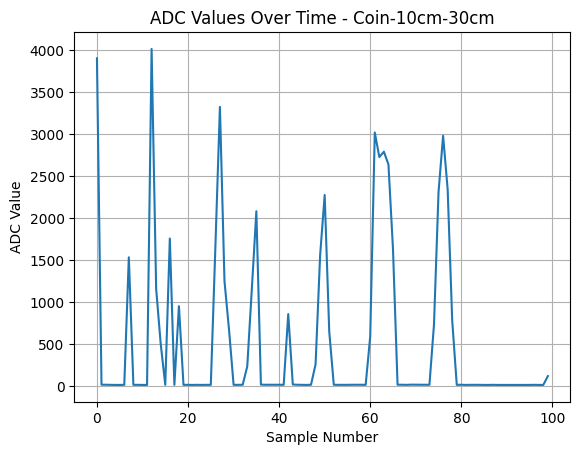

In [38]:
plt.plot(range(len(data)), data)  # Plot the ADC values
plt.xlabel("Sample Number")  # Label for the x-axis
plt.ylabel("ADC Value")  # Label for the y-axis
plt.title(f"ADC Values Over Time - {class_names[class_label]}")  # Title of the plot
plt.grid()  # Show grid lines on the plot
plt.show()  # Display the plot

# Fourier Transform
[Credit](https://www.youtube.com/watch?v=s2K1JfNR7Sc)

## For the latest data

### Compute the Fast Fourier Transform (FFT) and plot the Power Spectral Density (PSD)

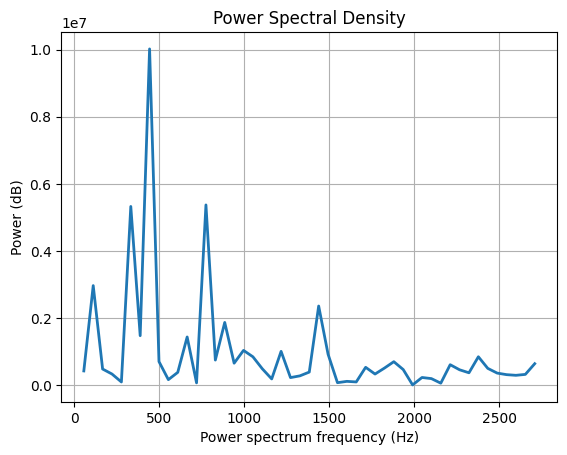

In [40]:
fs = 5530  # Sampling frequency in Hz

n = len(data)  # Number of samples

# Compute the FFT and Power Spectral Density (PSD)
fhat = np.fft.fft(data, n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (n * (1 / fs))) * np.arange(n)  # Frequency bins
L = np.arange(1, np.floor(n / 2), dtype='int')  # Positive frequencies

# Plot the Power Spectral Density
plt.plot(freq[L], PSD[L].real, linewidth=2)
plt.xlabel('Power spectrum frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

### Use the PSD to filter out noise

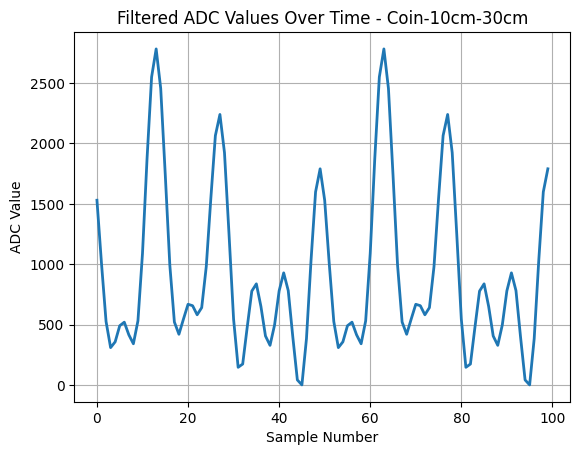

In [45]:
# Threshold the PSD to isolate significant frequencies
indices = PSD > 0.1 * np.max(PSD)  # Thresholding condition
fhat = fhat * indices     # Clean Fourier coefficients

# Inverse FFT to reconstruct the filtered signal
ffilt = np.fft.ifft(fhat).real  # Ensure real output

# Apply DC offset so the minimum value is 0
ffilt = ffilt + abs(min(0, np.min(ffilt)))

# Plot the filtered time-domain signal
plt.plot(range(len(data)), ffilt, linewidth=2)
plt.xlabel('Sample Number')
plt.ylabel('ADC Value')
plt.title(f"Filtered ADC Values Over Time - {class_names[class_label]}")
plt.grid()
plt.show()

## Fourier transform entire dataset for model training

In [ ]:
def fft(data):
    """
    Computes the FFT of the input data.
    Args:
        data (array-like): Input data to compute the FFT.
        fs (float): Sampling frequency.
    Returns:
        array: The filtered time-domain signal after applying the FFT and inverse FFT.
    """
    n = len(data)  # Number of samples
    
    fhat = np.fft.fft(data, n)  # Compute the FFT
    PSD = fhat * np.conj(fhat) / n  # Compute the Power Spectral Density
    indices = PSD > 0.1 * np.max(PSD)  # Thresholding condition
    fhat = fhat * indices  # Clean Fourier coefficients
    ffilt = np.fft.ifft(fhat).real  # Inverse FFT to reconstruct the filtered signal
    ffilt = ffilt + abs(min(0, np.min(ffilt))) # Apply DC offset so the minimum value is 0

    return ffilt

filepath = "data/data_test.csv"  # Name of the CSV file to read the data
df = pd.read_csv(filepath)  # Read the existing CSV file

# Create a new DataFrame to store FFT-transformed data
df_fft = pd.DataFrame(columns=df.columns)  # Initialize with the same columns as the original DataFrame

for i in range(len(df)):
    data = df.iloc[i, 1:].values  # Extract data values (excluding the label column)
    df_fft.loc[i] = [int(df.iloc[i, 0])] + list(fft(data))  # Apply FFT and save to new DataFrame

# Convert the label column to integers
df_fft["label"] = df_fft["label"].astype(int)

# Save the FFT-transformed data to a new CSV file
filepath_fft = filepath.replace("data_", "data_fft_")
df_fft.to_csv(filepath_fft, index=False)

# Train Classification Model

# Evaluate Classification Model

# Demo Run